In [3]:
# Preparing the environment

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from langchain_community.document_loaders import DataFrameLoader
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap



c:\Users\stiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# First, let's take a first look at the dataset

In [3]:
df = pd.read_csv("reviews_data.csv")

In [4]:
df.head(10)

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...
5,Alyssa,"Sunnyvale, TX","Reviewed Sept. 14, 2023",1.0,We had to correct them on our order 3 times. T...,['No Images']
6,ken,"Spring Hill, FL","Reviewed Sept. 8, 2023",1.0,I have tried Starbucks several different times...,['No Images']
7,Nikki,"Asheville, NC","Reviewed Aug. 25, 2023",1.0,Starbucks near me just launched new fall foods...,['No Images']
8,Alex,"Reisterstown, MD","Reviewed Aug. 5, 2023",1.0,"I ordered online for the Reisterstown Rd, St T...",['No Images']
9,Sunny,"Zionville, Other","Reviewed Aug. 4, 2023",1.0,Staff at the Smythe St. Superstore location in...,['No Images']


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [6]:
df = df.drop(columns="Image_Links")

In [7]:
df.head(-10)

,name,location,Date,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...,...,...,...
835,C.,"Allston, MA","Reviewed May 31, 2008",NaN,For the past several years I've stopped in to ...
836,Lynette,"Los Angeles, CA","Reviewed May 13, 2008",NaN,Found a hair inside of a rice crispy square.
837,Tenzin,"Woodside, NY","Reviewed March 17, 2008",NaN,On 3/15/08 I was at the Starbucks on 42nd stre...
838,Rob,"Las Vegas, NV","Reviewed Feb. 18, 2008",NaN,No Review Text


In [8]:
df.isna().sum()

name          0
location      0
Date          0
Rating      145
Review        0
dtype: int64

In [9]:
'''
    The main focus analysis: 
    1. Sentiment analysis from "Review Text":
        Step one: Data Cleaning. Need to verify "No Review Text" on Review Column
        Step two: Apply sentiment clustering (positive and negative) with unsupervised learning

'''


'\n    The main focus analysis: \n    1. Sentiment analysis from "Review Text":\n        Step one: Data Cleaning. Need to verify "No Review Text" on Review Column\n        Step two: Apply sentiment clustering (positive and negative) with unsupervised learning\n\n'

In [10]:
# Cleaning "No Review Text" column. I will need those comments, so let's drop the rows with "No Review Text"
df_filtered = df[df["Review"] == "No Review Text"]
len(df_filtered)

37

In [11]:
df = df[df["Review"] != "No Review Text"]

In [12]:
df.head(-10)

,name,location,Date,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...
...,...,...,...,...,...
829,Misty,"Lincoln, CA","Reviewed July 17, 2008",NaN,I then decided to call and ask her for her ma...
830,Mike,"New York, NY","Reviewed July 14, 2008",NaN,Walked into buy a cup of coffee today and the ...
831,Raudys,"Miami Beach, FL","Reviewed July 13, 2008",NaN,"Ordered two dopio machiato coffees, however I ..."
832,Lou,"Hackesnack, NJ","Reviewed June 16, 2008",NaN,I stop at this Starbucks quite often. They ha...


In [13]:
# Ok! first cleaning problem solved. I have 803 rows with reviews on it. For my first purpose: Sentiment Analysis
text = df["Review"]

In [18]:
# Preprocessing data for trainning:

def clean_review(text):
    if pd.isnull(text):
        return ''
    text = text.lower()  # lower case
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'[^a-záéíóúâêîôûãõç\s]', '', text)  # remove simbols, ponctuation and emojis
    text = re.sub(r'\s+', ' ', text)  # removes a lot of whitespace
    return text.strip()

# Applying to "Review" column
df['review_cleaned'] = df['Review'].apply(clean_review)

# Let's see the first rows
print(df[['Review', 'review_cleaned']].head())


                                              Review  \
0  Amber and LaDonna at the Starbucks on Southwes...   
1  ** at the Starbucks by the fire station on 436...   
2  I just wanted to go out of my way to recognize...   
3  Me and my friend were at Starbucks and my card...   
4  I’m on this kick of drinking 5 cups of warm wa...   

                                      review_cleaned  
0  amber and ladonna at the starbucks on southwes...  
1  at the starbucks by the fire station on in alt...  
2  i just wanted to go out of my way to recognize...  
3  me and my friend were at starbucks and my card...  
4  im on this kick of drinking cups of warm water...  


In [19]:
# Vectorizing
vetor = TfidfVectorizer(stop_words='english', max_features=5000)
X = vetor.fit_transform(df['review_cleaned'].dropna())

# Aplica clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)

# Adiciona cluster no DataFrame
df['cluster'] = -1
df.loc[df['review_cleaned'].notna(), 'cluster'] = kmeans.labels_

In [20]:
# Isolating "review_cleaned" and "cluster" columns
df_review_cleaned = df[["review_cleaned", "cluster"]]
print(df_review_cleaned)

                                        review_cleaned  cluster
0    amber and ladonna at the starbucks on southwes...        1
1    at the starbucks by the fire station on in alt...        0
2    i just wanted to go out of my way to recognize...        1
3    me and my friend were at starbucks and my card...        1
4    im on this kick of drinking cups of warm water...        1
..                                                 ...      ...
841  when using my debit card how much and for how ...        1
842  i just bought a starbucks thermos mug about a ...        1
844  im was a regular customer who ordered a latte ...        1
845  i ordered two venti frappacinos without whippe...        1
847  demanded tips from me then made me wait until ...        1

[813 rows x 2 columns]


In [21]:
print("\n🔴 Cluster NEGATIVE examples:")
print(df_review_cleaned[df_review_cleaned["cluster"] == 1]["review_cleaned"].sample(5).tolist())

print("\n🟢 Cluster POSITIVE examples:")
print(df_review_cleaned[df_review_cleaned["cluster"] == 0]["review_cleaned"].sample(5).tolist())



🔴 Cluster NEGATIVE examples:
['recently i have gone to your starbucks at barry rd in kansas city mo and most of the employees are professional and nice to deal with a certain brittney with a bad attitude most of the time remarked to me well you never tip us in the most hateful way and in front of two other female employees too it was quite embarrassing for me', 'we ordered online paid but they lost order so i had to reorder pay while my daughter tried to get her refund from first order then they mangled the order she requested a caramel macchiato but they didnt mix it caramel sat on bottom they just poured milk in it i ordered strawberry refresher with extra strawberry somehow they made it slightly bitter i heard them express to a man that waited for min for plain black coffee that they where trying but didnt really know how to make coffee seriously this terrible dont go to mad river store near dayton mall they suck', 'this is the first time i go to this store located in bristol and t

In [22]:
df_review_cleaned["cluster"].value_counts()

cluster
1    646
0    167
Name: count, dtype: int64

In [23]:
#Ok, so I have checked by my own and it doesn't sound correct. So right now, I am going to recheck calculating the silhouette score
score = silhouette_score(X, df_review_cleaned["cluster"])
print(f"Silhouette Score: {score}")

#Damn, this is not good!

Silhouette Score: 0.0036639154963545835


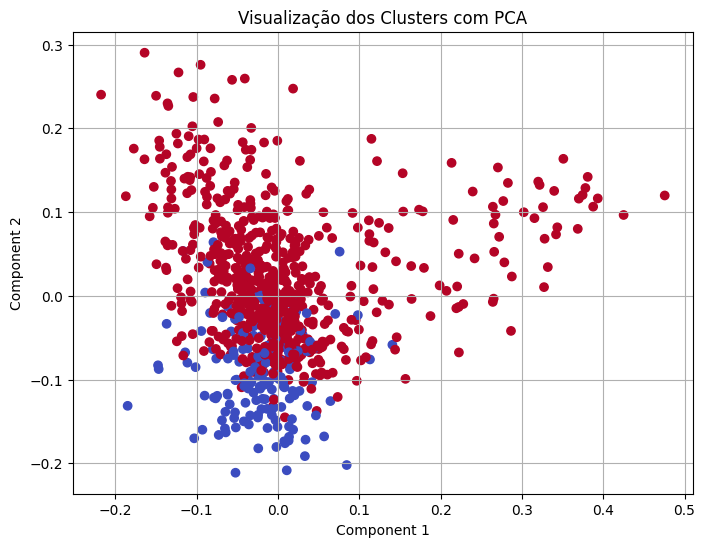

In [24]:
# Let's see this with some graphical visualization
pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(components[:, 0], components[:, 1], c=(df_review_cleaned["cluster"] == 1), cmap='coolwarm')
plt.title("Visualização dos Clusters com PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [25]:
#Okay, so the clustering was not effective. I’ll try a different approach to text representation, using OpenAI embeddings instead of Tf-Idf vectorizing
df


,name,location,Date,Rating,Review,review_cleaned,cluster
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,amber and ladonna at the starbucks on southwes...,1
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,at the starbucks by the fire station on in alt...,0
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,i just wanted to go out of my way to recognize...,1
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,me and my friend were at starbucks and my card...,1
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,im on this kick of drinking cups of warm water...,1
...,...,...,...,...,...,...,...
841,Mary,"Hillsboro, OR","Reviewed Dec. 16, 2007",NaN,"When using my debit card, how much and for how...",when using my debit card how much and for how ...,1
842,Angie,"Innsbruck, OR","Reviewed Sept. 17, 2007",NaN,I just bought a starbucks thermos mug about a ...,i just bought a starbucks thermos mug about a ...,1
844,Sabine,"Redondo Beach, CA","Reviewed Dec. 19, 2006",NaN,I'm (was) a regular customer who ordered a lat...,im was a regular customer who ordered a latte ...,1
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,i ordered two venti frappacinos without whippe...,1


In [26]:
#Excluding Tf-Idf clustering column
df.drop(columns="cluster")

,name,location,Date,Rating,Review,review_cleaned
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,amber and ladonna at the starbucks on southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,at the starbucks by the fire station on in alt...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,i just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,me and my friend were at starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,im on this kick of drinking cups of warm water...
...,...,...,...,...,...,...
841,Mary,"Hillsboro, OR","Reviewed Dec. 16, 2007",NaN,"When using my debit card, how much and for how...",when using my debit card how much and for how ...
842,Angie,"Innsbruck, OR","Reviewed Sept. 17, 2007",NaN,I just bought a starbucks thermos mug about a ...,i just bought a starbucks thermos mug about a ...
844,Sabine,"Redondo Beach, CA","Reviewed Dec. 19, 2006",NaN,I'm (was) a regular customer who ordered a lat...,im was a regular customer who ordered a latte ...
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,i ordered two venti frappacinos without whippe...


In [27]:
# Applying SBERT embedding, with the model all-miniLM
model = SentenceTransformer('all-mpnet-base-v2') 

# Creating embeddings
df["sbert-embedding"] = df["review_cleaned"].apply(
    lambda x: model.encode(x)
)

In [28]:
# So, let's try clustering again
# Transforming embeddings in array
X = np.array(df["sbert-embedding"].tolist())

# Applying K-means once again and insert the column with the new "cluster" into de dataframe
kmeans = KMeans(n_clusters=2, random_state=42)
df["cluster"] = kmeans.fit_predict(X)



In [29]:
df

,name,location,Date,Rating,Review,review_cleaned,cluster,sbert-embedding
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,amber and ladonna at the starbucks on southwes...,0,"[-0.02072011, 0.0036816704, 0.0087555945, 0.03..."
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,at the starbucks by the fire station on in alt...,0,"[-0.022621397, 0.015892174, -0.021919947, -0.0..."
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,i just wanted to go out of my way to recognize...,1,"[-0.04055268, 0.025248436, -0.011620719, 0.003..."
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,me and my friend were at starbucks and my card...,1,"[-0.047204737, -0.011216017, -0.0024879791, -0..."
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,im on this kick of drinking cups of warm water...,0,"[-0.02064847, 0.015221805, 0.002832325, -0.000..."
...,...,...,...,...,...,...,...,...
841,Mary,"Hillsboro, OR","Reviewed Dec. 16, 2007",NaN,"When using my debit card, how much and for how...",when using my debit card how much and for how ...,1,"[0.05490175, -0.045150407, -0.034123484, -0.01..."
842,Angie,"Innsbruck, OR","Reviewed Sept. 17, 2007",NaN,I just bought a starbucks thermos mug about a ...,i just bought a starbucks thermos mug about a ...,1,"[0.045837954, -0.008817583, -0.021220615, 0.03..."
844,Sabine,"Redondo Beach, CA","Reviewed Dec. 19, 2006",NaN,I'm (was) a regular customer who ordered a lat...,im was a regular customer who ordered a latte ...,1,"[0.03678084, 0.042039383, 0.005593137, 0.01073..."
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,i ordered two venti frappacinos without whippe...,0,"[0.05695039, 0.044511456, -0.028125878, -0.004..."


In [29]:
# Let's reconsider trying to analysis some samples of negative and positive examples
print("\n🔴 Cluster NEGATIVE examples:")
print(df[df["cluster"] == 1]["review_cleaned"].sample(1).tolist())

print("\n🟢 Cluster POSITIVE examples:")
print(df[df["cluster"] == 0]["review_cleaned"].sample(1).tolist())


🔴 Cluster NEGATIVE examples:
['had a few bad experiences at a local starbucks out of the last drinks were wrong so i wrote a complaint to starbucks customer relations about a day later i got an email that even said they would look into the service at at location about weeks later i got a letter and free drink cards sent i definitely think its a step in the right directions some locations have offered great service and this location continued to provide subpar even at times bad service the reply although wont fix the location its a hope it might and definitely more than i have ever received from mcdonalds the s of times ive complaint about a particular location primarily the one right next to my house so yes all in all the overall customer service i have received from starbucks have been positive attached the letter and coupons had to cut of the top half of the letter because my name is in it and unfortunately it also cropped out the starbucks header']

🟢 Cluster POSITIVE examples:
['b

In [30]:
df["cluster"].value_counts()

cluster
1    433
0    380
Name: count, dtype: int64

In [31]:
# The cluster is different from Tf-Idf. So, now let's calculate the silhouette score
score = silhouette_score(X, df["cluster"])
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0659


In [32]:
#Okay, the silhouette score is still pretty low, but it has shown an improvement from the Tf-Idf approach. 


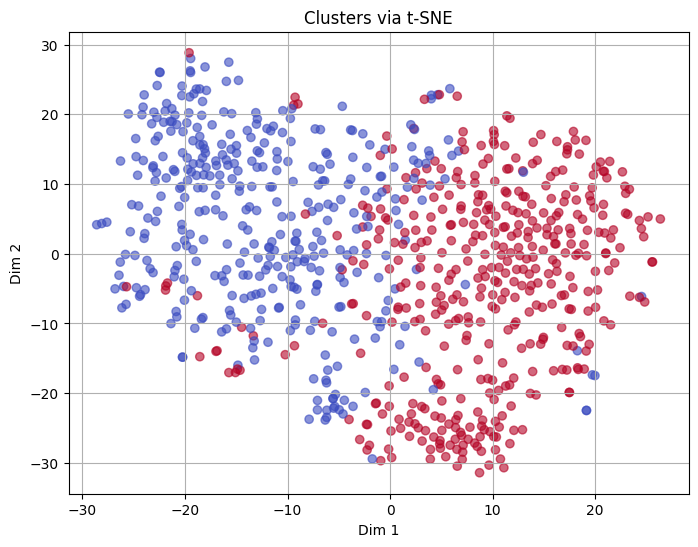

In [33]:
# Let's see the graph visualization, remember: value 0 -> positive reviews, value 1 -> negative reviews
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=(df["cluster"] == 1), cmap='coolwarm', alpha=0.6)
plt.title("Clusters via t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

c:\Users\stiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\stiag\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


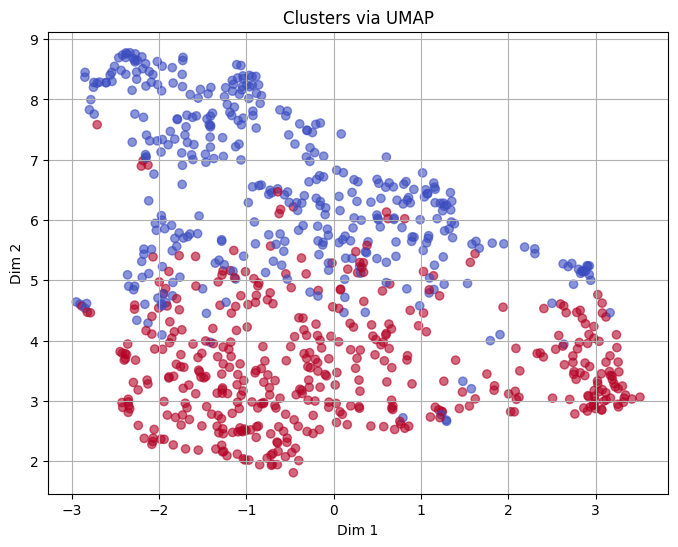

In [34]:
# Let's use UMAP visualization
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=(df["cluster"] == 1),  
    cmap='coolwarm',
    alpha=0.6
)
plt.title("Clusters via UMAP")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [1]:
# I didn't get a great result, but this project was about trainning and learning!